# The Image Classification Dataset
I have a **weird problem**. I need to have everything in mind, to sink it 100%. 

That thing is causing issues. Here, they will present the DataLoader, but I need to first **rewind  bit** and understand the initials of the DataLoader class.

Let's. See.

In [3]:
%matplotlib inline
import time
import torch
import torchvision

## vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv ##
from torchvision import transforms
## ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ##
from d2l import torch as d2l

d2l.use_svg_display()

<img src="../images/initial-core.png">

## Loading the Dataset

Since the Fashion-MNIST dataset is so useful, all major frameworks provide preprocessed versions of it. We can  [**download and read it into memory using built-in framework utilities.**]


In [6]:
torchvision.datasets.FashionMNIST(root="../data", train=False, download=True)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

In [7]:
class FashionMNIST(d2l.DataModule):  #@save
    """
    RULE: Whenever you're loading the data or doing something with it, 
    try to *create* a class first.

    That will handle the stuff, like loading - giving batches - manipulating
    etc. 

    It keeps the stuff handy. 
    """
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__() # it will initialize self.root and num_workers (image above)
        self.save_hyperparameters()

        # ✨ this is the pipeline that we are setting **classic one!**
        trans = transforms.Compose([transforms.Resize(resize), # resize the image
                                    transforms.ToTensor()])    # mamke it tensor-friendly
        
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

Doing above will create the files like this 👇🏻

<img src="../images/data-folder.png">

- The red is **train**
- The blue is **test**

Fashion-MNIST consists of images from 10 categories, each represented
by 6000 images in the training dataset and by 1000 in the test dataset.
A *test dataset* is used for evaluating model performance (it must not be used for training).
Consequently the training set and the test set
contain 60,000 and 10,000 images, respectively.


In [8]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

(60000, 10000)

The above has `downloaded - loaded - transformed` the data. 

- Training has `60000` images
    - 10 categories and each will have 6000 images
    - Thus it will make it 60000 (60K)
- Testing has `1000` images
    - 10 categories and each will have 1000 images
    - Thus it will make it 10000 (10K)

In [12]:
# A little WTFFFF!?
type(data.train)

torchvision.datasets.mnist.FashionMNIST

In [23]:
# The possible 10 categories
data.train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [26]:
# The *actual data*
data.train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [39]:
# Well... what? 28 x 28?
data.train.data.shape

torch.Size([60000, 28, 28])

---

> This means **we have 2 copies of the data**: 1) The untransformed 2) The transformed. The above is what we are accessing **without transforming them**. The below... just see! 👇🏻 


---


The images are grayscale and upscaled to $32 \times 32$ pixels in resolution above. This is similar to the original MNIST dataset which consisted of (binary) black and white images. Note, though, that most modern image data has three channels (red, green, blue) and that hyperspectral images can have in excess of 100 channels (the HyMap sensor has 126 channels).
By convention we store an image as a $c \times h \times w$ tensor, where $c$ is the number of color channels, $h$ is the height and $w$ is the width.


In [40]:
data.train[0][0].shape

torch.Size([1, 32, 32])

In [42]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator
[**reads a minibatch of data with size `batch_size`.**]
We also randomly shuffle the examples for the training data iterator.


In [80]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val # send the data to the "mini batch producer"
    return torch.utils.data.DataLoader(dataset=data, 
                                       batch_size=self.batch_size,
                                       shuffle=train,
                                       num_workers=self.num_workers)

The above is a **replica of what we did with the manual version** see below 👇🏻 

<img src="../images/dataloader.png">

> So basically we are taking the index, shuffling it and returning based on the mode of the data
>
> That's exactly what the `torch.DataLoader` version does, but **fast!**

To see how this works, let's load a minibatch of images by invoking the `train_dataloader` method. It contains 64 images.


<img src="../images/data-module-train-test.png">

In [81]:
X, y = next(iter(data.train_dataloader())) # this will give the train loader
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [82]:
X, y = next(iter(data.val_dataloader())) # this will give the val loader
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


Let's look at the time it takes to read the images. Even though it is a built-in loader, **it is not blazingly fast**. Nonetheless, this is sufficient since processing images with a deep network takes quite a bit longer. Hence it is good enough that training a network will not be I/O constrained.

In [83]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'2.89 sec'

## Visualization

We will often be using the Fashion-MNIST dataset. A convenience function `show_images` can be used to visualize the images and the associated labels. 
Skipping implementation details, we just show the interface below: we only need to know how to invoke `d2l.show_images` rather than how it works
for such utility functions.


In [84]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    raise NotImplementedError

Let's put it to good use. In general, it is a good idea to visualize and inspect data that you are training on. 
Humans are very good at spotting oddities and because of that, visualization serves as an additional safeguard against mistakes and errors in the design of experiments. Here are [**the images and their corresponding labels**] (in text)
for the first few examples in the training dataset.


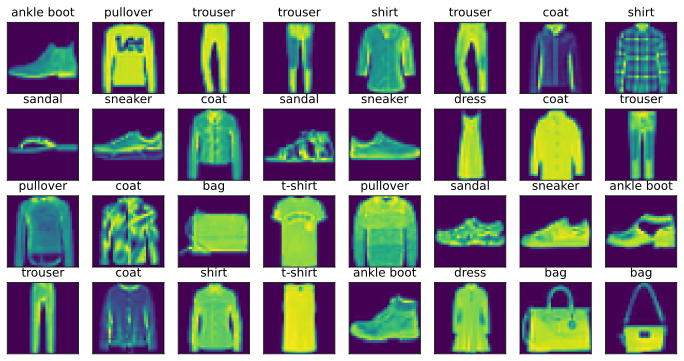

In [85]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch, nrows=4, ncols=8)

In [86]:
X, y = next(iter(data.train_dataloader())) # this will give the train loader
X.shape, y.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

In [87]:
X.squeeze(1).shape

torch.Size([64, 32, 32])

We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

We now have a slightly more realistic dataset to use for classification. Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various network designs, from a simple linear model to advanced residual networks. As we commonly do with images, we read them as a tensor of shape (batch size, number of channels, height, width). For now, we only have one channel as the images are grayscale (the visualization above uses a false color palette for improved visibility). 

Lastly, data iterators are a key component for efficient performance. For instance, we might use GPUs for efficient image decompression, video transcoding, or other preprocessing. Whenever possible, you should rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


## Exercises

1. Does reducing the `batch_size` (for instance, to 1) affect the reading performance?
1. The data iterator performance is important. Do you think the current implementation is fast enough? Explore various options to improve it. Use a system profiler to find out where the bottlenecks are.
1. Check out the framework's online API documentation. Which other datasets are available?


[Discussions](https://discuss.d2l.ai/t/49)
